In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rc('xtick', labelsize = 8) 
matplotlib.rc('ytick', labelsize = 8)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm
import cartopy.feature as cft

from sklearn import preprocessing
import xgcm
from xhistogram.xarray import histogram

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

import dask
dask.config.set({'logging.distributed': 'error'})

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45713/status,
Dashboard: /proxy/45713/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33581,Workers: 4
Dashboard: /proxy/45713/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:45175,Total threads: 4
Dashboard: /proxy/33577/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43199,


In [4]:
db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control_hh5.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_heat_hh5.db'
session_heat = cc.database.create_session(db)

session = [session_heat, session_heat, session_cont]
expt = ['025deg_jra55_ryf_fluxH_neg10W', '025deg_jra55_ryf_fluxH_neg5W', '025deg_jra55_ryf_control']
name = ['-15 W m$^{-2}$', '-7.5 W m$^{-2}$', 'Control']

## 1. Time-series and bar graphs

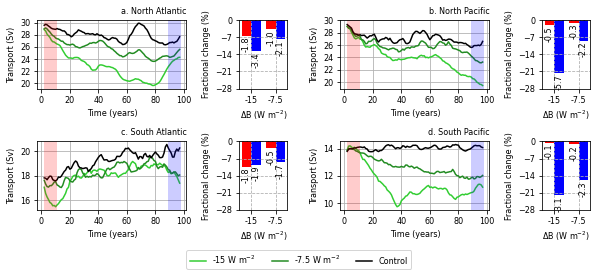

In [5]:
## Plotting attributes
name_basin = ['a. North Atlantic', 'b. North Pacific', 'c. South Atlantic', 'd. South Pacific']
color_ts = ['limegreen', 'forestgreen', 'Black']

## First 10 vs last 10 years are highlighted in red and blue respectively
st = [2,  87]
et = [12, 97]

## Bar graph attributes
color_bar = ['red', 'blue']
basin = ['NA', 'NP', 'SA', 'SP']
xlabels = ['-15', '-7.5']

## creating grid for subplots
fig = plt.figure()
fig.set_figheight(4*1.2)
fig.set_figwidth(7*1.2)

for i, j in enumerate(basin):
    
    ## Plotting time-series first
    axes = plt.subplot2grid(shape=(3, 6), loc=(int(i/2), int(i%2)*3), colspan=2)
    psi = xr.open_dataset('NETCDF/Gyre_95th/' + j + '_STG/psi_iso95_neg_STG.nc')
    psi = psi.to_array().mean('variable')
    
    ## If-else statement to only do label = name[i] once in legend
    if(i == 0):
        if(j == 'NA'):
            for k in np.linspace(0, 2, 3):
                psi.isel(expt = int(k)).plot(ax = axes, color = color_ts[int(k)], label = name[i])
        else:
            for k in np.linspace(0, 2, 3):
                (-1 * psi.isel(expt = int(k))).plot(ax = axes, color = color_ts[int(k)], label = name[i])
    else:
        if(j == 'NA' or j == 'NP'):
            for k in np.linspace(0, 2, 3):
                psi.isel(expt = int(k)).plot(ax = axes, color = color_ts[int(k)])
        else:
            for k in np.linspace(0, 2, 3):
                (-1 * psi.isel(expt = int(k))).plot(ax = axes, color = color_ts[int(k)])
    
    ## y-ticks for different gyres
    if(i == 0):
        axes.set_yticks([20, 22, 24, 26, 28, 30])
    elif(i == 1):
        axes.set_yticks([20, 22, 24, 26, 28, 30])
    elif(i == 2):
        axes.set_yticks([16, 18, 20])
    elif(i == 3):
        axes.set_yticks([10, 12, 14])
    
    ## Plotting specifications
    axes.grid()
    axes.set_ylabel('Transport (Sv)', fontsize = 8)
    axes.set_xlabel('Time (years)', fontsize = 8)
    axes.set_title('')
    axes.set_title(name_basin[i], fontsize = 8, loc='right')
    
    ## First 10 vs last 10 years highlighting
    axes.axvline(x = 6, color = 'red', label = 'axvline - full height', alpha = 0.2, lw = 13)
    axes.axvline(x = 93, color = 'blue', label = 'axvline - full height', alpha = 0.2, lw = 13)
    
    ## Bar graph plotting
    axes = plt.subplot2grid(shape=(3, 6), loc=(int(i/2), 2 + int(i%2)*3), colspan=1)
    
    ## Removing control experiment from data, finding absolute and fractional differences with control
    del_psi = (psi - psi.sel(expt = '025deg_jra55_ryf_control'))[:, 0:2]
    del_perc = 100 * (psi/psi.sel(expt = '025deg_jra55_ryf_control') - 1)[:, 0:2]
    
    xval = np.array([1, 2])

    for k in (xval-1):
        psi_vals = del_perc.sel(time = slice(st[k], et[k])).mean('time')
        plt.bar(xval - 0.2 + 0.4 * k, psi_vals, width = 0.4, color = color_bar[k])

        count = -1
        for l, m, x in zip(xval - 0.2 + 0.4 * k, psi_vals, psi_vals):
            count = count + 1
            if(i == 0 or i == 1):
                plt.text(l, m - 6, np.round(del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), fontsize = 8, ha = 'center', rotation = 'vertical')
            else:
                plt.text(l, m - 6, np.round(-1 * del_psi.isel(expt = count).sel(time = slice(st[k], et[k])).mean('time').values, 1), fontsize = 8, ha = 'center', rotation = 'vertical')

    #Bar graph attributes
    axes.set_xticks(ticks = xval, labels = xlabels)
    axes.set_ylabel('Fractional change (%)', fontsize = 8)
    axes.set_xlabel('$\Delta$B (W m$^{-2}$)', fontsize = 8)
    axes.set_yticks([-28, -21, -14, -7, 0])
    axes.grid(linestyle='--')
    axes.set_title('')
    
fig.legend(name, bbox_to_anchor = (0.5, 0.2), loc = 'lower center', ncol = 3, fontsize = 8)
plt.tight_layout()

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_neg/All_gyres2.pdf', 
#            bbox_inches = 'tight', dpi = 900, transparent=True)

## 2. Atlantic basin buoyancy anomaly plots

In [11]:
rho0 = 1036
start_time = '2202-01-01'
end_time = '2301-12-31'

st = ['2204-12-31', '2247-01-01', '2292-01-01']
et = ['2213-12-31', '2256-12-31', '2301-12-31']

expt_cell = ['025deg_jra55_ryf_fluxH_neg5W', '025deg_jra55_ryf_fluxH_neg10W']

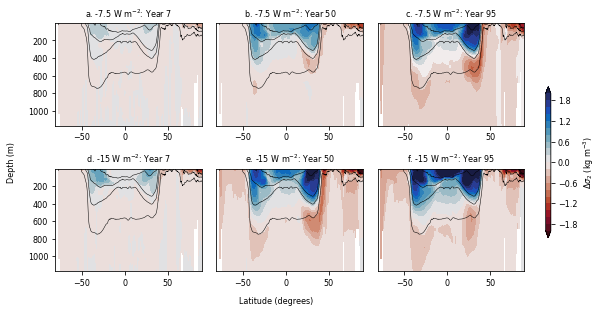

In [7]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (6 * 1.2, 3.5 * 1.2))

## Control experiment potential density used for black contours
pcont = cc.querying.getvar(expt[2], 'pot_rho_2',session = session[2], start_time = start_time, end_time = end_time, use_cftime = True) - 1000
pcont_c = pcont.sel(time = slice(start_time, end_time)).mean('time')

## Looping through the two reduced surface buoyancy flux contrast experiments
for i, j in enumerate(expt_cell):
    if(i == 0):
        name_save = ['a. -7.5 W m$^{-2}$: Year 7', 'b. -7.5 W m$^{-2}$: Year 50', 'c. -7.5 W m$^{-2}$: Year 95']
    else:
        name_save = ['d. -15 W m$^{-2}$: Year 7', 'e. -15 W m$^{-2}$: Year 50', 'f. -15 W m$^{-2}$: Year 95']
    for k in np.arange(0, len(st), 1):
        
        potrho = cc.querying.getvar(expt_cell[i], 'pot_rho_2',session = session_heat, start_time = st[k], end_time = et[k], use_cftime = True) - 1000
        potrho = potrho.sel(time = slice(st[k], et[k]))
        
        ## Plotting control contours on top of potential density anomalies
        pcont_c.sel(xt_ocean = slice(-60, -30)).mean('xt_ocean').sel(st_ocean = slice(0, 1200)).plot.contour(levels = [26, 32, 34, 35, 36], cmap = 'Black', linewidths = 0.5, ax = ax[i][k])
        pcont_cf = pcont.sel(time = slice(st[k], et[k]))
        
        ## Maps of 0-1200 m buoyancy anomalies for a longitudinal slice (-60, -30) of the Atlantic Ocean 
        p1 = (potrho - pcont_cf).mean('time').sel(xt_ocean = slice(-60, -30)).mean('xt_ocean').sel(st_ocean = slice(0, 1200)).plot.contourf(cmap = cm.cm.balance_r, levels = np.linspace(-2, 2, 21), ax = ax[i][k], add_colorbar = False)
        ax[i][k].invert_yaxis()
        ax[i][k].set_xlabel('')
        ax[i][k].set_ylabel('')
        ax[i][k].set_title(name_save[k], fontsize = 8)
        
        ## Plotting y-ticks only for the first column
        if(k!=0):
            ax[i][k].set_yticks([])
        
## Plotting attributes
cax = plt.axes([1.02, 0.2, 0.01, 0.5])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical')
cb.set_label('$\Delta \sigma_2$ (kg m$^{-3}$)', fontsize = 8)
fig.text(0.5, -0.01, 'Latitude (degrees)', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 8)
fig.text(-0.01, 0.45, 'Depth (m)', va = 'center', ha = 'center', rotation = 'vertical', fontsize = 8)
plt.tight_layout()

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_neg/Stratification_anomalies_Atlantic.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)

## 3. Pacific basin buoyancy anomaly plots

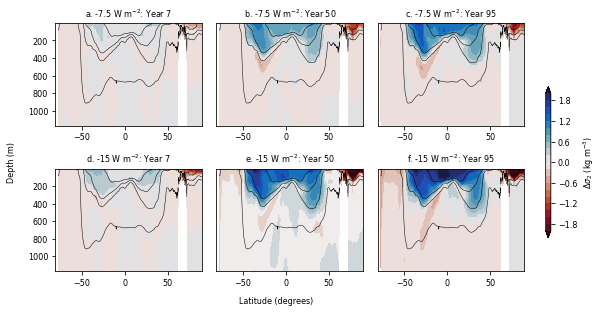

In [8]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (6 * 1.2, 3.5 * 1.2))

## Control experiment potential density used for black contours
pcont = cc.querying.getvar(expt[2], 'pot_rho_2',session = session[2], start_time = start_time, end_time = end_time, use_cftime = True) - 1000
pcont_c = pcont.sel(time = slice(start_time, end_time)).mean('time')

## Looping through the two reduced surface buoyancy flux contrast experiments
for i, j in enumerate(expt_cell):
    if(i == 0):
        name_save = ['a. -7.5 W m$^{-2}$: Year 7', 'b. -7.5 W m$^{-2}$: Year 50', 'c. -7.5 W m$^{-2}$: Year 95']
    else:
        name_save = ['d. -15 W m$^{-2}$: Year 7', 'e. -15 W m$^{-2}$: Year 50', 'f. -15 W m$^{-2}$: Year 95']
    for k in np.arange(0, len(st), 1):
        
        potrho = cc.querying.getvar(expt_cell[i], 'pot_rho_2',session = session_heat, start_time = st[k], end_time = et[k], use_cftime = True) - 1000
        potrho = potrho.sel(time = slice(st[k], et[k]))
        
        ## Plotting control contours on top of potential density anomalies
        pcont_c.sel(xt_ocean = slice(-220, -140)).mean('xt_ocean').sel(st_ocean = slice(0, 1200)).plot.contour(levels = [26, 32, 34, 35, 36], cmap = 'Black', linewidths = 0.5, ax = ax[i][k])
        pcont_cf = pcont.sel(time = slice(st[k], et[k]))
        
        ## Maps of 0-1200 m buoyancy anomalies for a longitudinal slice (-220, -140) of the Pacific Ocean 
        p1 = (potrho - pcont_cf).mean('time').sel(xt_ocean = slice(-220, -140)).mean('xt_ocean').sel(st_ocean = slice(0, 1200)).plot.contourf(cmap = cm.cm.balance_r, levels = np.linspace(-2, 2, 21), ax = ax[i][k], add_colorbar = False)
        ax[i][k].invert_yaxis()
        ax[i][k].set_xlabel('')
        ax[i][k].set_ylabel('')
        ax[i][k].set_title(name_save[k], fontsize = 8)
        
        ## Plotting y-ticks only for the first column
        if(k!=0):
            ax[i][k].set_yticks([])
        
## Plotting attributes
cax = plt.axes([1.02, 0.2, 0.01, 0.5])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical')
cb.set_label('$\Delta \sigma_2$ (kg m$^{-3}$)', fontsize = 8)
fig.text(0.5, -0.01, 'Latitude (degrees)', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 8)
fig.text(-0.01, 0.45, 'Depth (m)', va = 'center', ha = 'center', rotation = 'vertical', fontsize = 8)
        
plt.tight_layout()

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_neg/Stratification_anomalies_Pacific.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)

## 4. Large-scale circulation plots

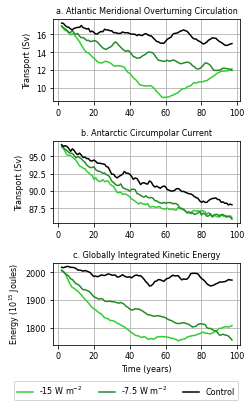

In [14]:
time_val = np.linspace(0 + 2, 95 + 2, 96)

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (3*1.2, 4.5*1.2))

for i, j in enumerate(session):
    
    ## Plotting AMOC
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = session[i], use_cftime = True, start_time = start_time, end_time = end_time).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc = psi_amoc.sel(time = slice(start_time, end_time))
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    axes[0].plot(time_val, psi_amoc_sum.rolling(time = 5, center = True).mean().dropna("time"), label = name[i], color = color_ts[i])
    axes[0].set_xlabel('', fontsize = 8)
    axes[0].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[0].set_title('a. Atlantic Meridional Overturning Circulation', fontsize = 8)

    ## Plotting DP Transport
    xmin, ymin, ymax = -69.9, -71.6, -51.0
    
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = session[i], use_cftime = True).sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.sel(time = slice(start_time, end_time))
    DP_trans = DP_trans.coarsen({"time": 12}, boundary = "trim").mean()
    axes[1].plot(time_val, DP_trans.rolling(time = 5, center = True).mean().dropna("time"), color = color_ts[i])
    axes[1].set_xlabel('', fontsize = 8)
    axes[1].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[1].set_title('b. Antarctic Circumpolar Current', fontsize = 8)
    
    ## Plotting globally integrated KE
    ke = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'ke_tot', use_cftime = True)
    ke = ke.sel(time = slice(start_time, end_time))
    ke = ke.coarsen({"time": 364}, boundary = "trim").mean()
    axes[2].plot(time_val, ke.rolling(time = 5, center = True).mean().dropna("time"), color = color_ts[i])
    axes[2].set_xlabel('Time (years)', fontsize = 8)
    axes[2].set_ylabel('Energy ($10^{15}$ Joules)', fontsize = 8)
    axes[2].set_title('c. Globally Integrated Kinetic Energy', fontsize = 8)
    
axes[0].grid()
axes[1].grid()
axes[2].grid()
    
fig.legend(bbox_to_anchor = (0.5, -0.05), loc = 'lower center', ncol = 3, fontsize = 8)
plt.tight_layout()
#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Buoyancy_neg/MOC_exceptAABW.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)